# Student number: 202125489

# Assignment

## 771767 - AI-Based Offensive Text Detection System (Natural Lnaguage Processing)

# Dependencies

In [2]:
#!pip install tensorflow_text

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec, FastText, KeyedVectors
import gensim.downloader as api
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Input, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

---

# Load data

Here the data used in the research is loaded using pandas. Two datasets are load namely:
- Twitter hate and offensive language dataset: tweets are labelled in three categories which are hate speech, offensive language and neither. [link](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset)
- Tweets dataset: tweets are labelled in three categories namely positive, negative and neutral. [link](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset)

In [4]:
#load dataset into dataframe
twitter_df1 = pd.read_csv('twitter_hate_speech_and_offensive_lang.csv')
twitter_df2 = pd.read_csv('Tweets.csv')

In [5]:
twitter_df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
twitter_df2.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
#create a new column for tweet label and map class accordingly
twitter_df1['label'] = twitter_df1['class'].map({0:'hate_speech',1:'offensive_language',2:'neither'})
twitter_df1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,label
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [8]:
#reduce dataframe to only the needed columns: tweets, label
twitter_df1 = twitter_df1[['tweet','label']]
twitter_df1.head()

,tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [9]:
#rename column accordingly
twitter_df2 = twitter_df2[['selected_text','sentiment']].rename(columns={'selected_text': 'tweet', 'sentiment': 'label'})
twitter_df2.head()

,tweet,label
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


---

# Data Cleaning

The text is cleaned by removing irrelevant items like punctuations, mentions, hashtags, links. stop words are also removed and lemmization applied.

In [13]:
# text cleaning function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuations, links, mentions, hashtags
       remove words containing numbers, remove stopwords and apply lemmatization.'''
    text = str(text).lower() #make lower case
    text = re.sub('\[.*?\]', ' ', text) #remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', ' ', text) #remove links
    text = re.sub('rt|cc', ' ', text) #remove rt and cc
    text = re.sub('@\S+', ' ', text) #remove mentions
    text = re.sub('#\S+', ' ', text) #remove hastags
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuations
    text = re.sub('\n', ' ', text) #remove newlines
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\s+', ' ', text) #remove extra white spaces

    #remove stopwords
    stop_words = stopwords.words('english') #initialize stopwords object
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)

    #apply lemmatization
    lemmatizer=WordNetLemmatizer() #initialize lemmatizing object
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))

    return text

In [14]:
#clean text by applying clean_text function to each row
twitter_df1['tweet_clean'] = twitter_df1['tweet'].apply(clean_text)
twitter_df1.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [15]:
#apply text cleaning function to twitter_df2
twitter_df2['tweet_clean'] = twitter_df2['tweet'].apply(clean_text)
twitter_df2.head()

,tweet,label,tweet_clean
0,"I`d have responded, if I were going",neutral,responded going
1,Sooo SAD,negative,sooo sad
2,bullying me,negative,bullying
3,leave me alone,negative,leave alone
4,"Sons of ****,",negative,son


---

# Visualization

Visualization of the class distribution. class imbalance is handled by merging the two datasets with the right proportion of classes.
word cloud visualization to visualize most occuring words in each class.

In [16]:
#distribution of label classes
balance_counts1= twitter_df1.groupby('label')['label'].agg('count').values
balance_counts1

array([ 1430,  4163, 19190])

In [17]:
balance_counts2= twitter_df2.groupby('label')['label'].agg('count').values
balance_counts2

array([ 7781, 11118,  8582])

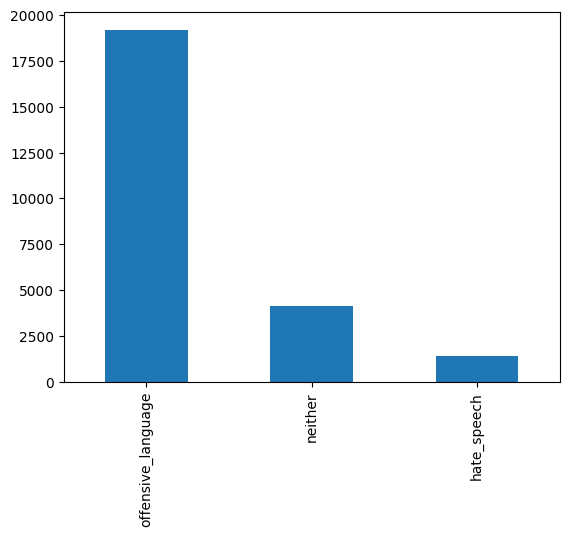

In [18]:
#plot distribution of label classes
twitter_df1['label'].value_counts().plot(kind='bar')
plt.show()

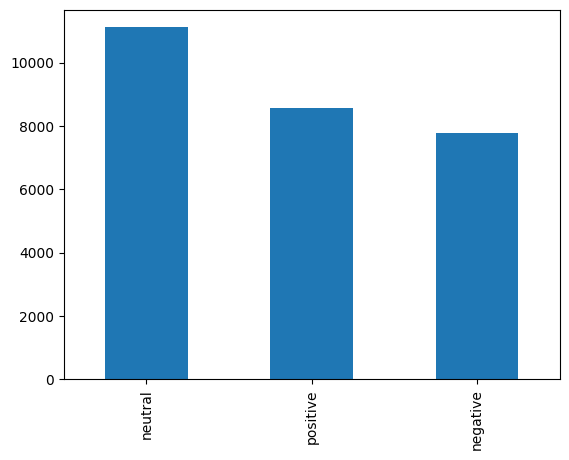

In [19]:
twitter_df2['label'].value_counts().plot(kind='bar')
plt.show()

In [20]:
#select non-offensive tweets by selecting only positive and neutral labels and shuffle
non_offensive_df = twitter_df2[(twitter_df2.label=='neutral')|(twitter_df2.label=='positive')].sample(frac=1).reset_index(drop=True)

non_offensive_df.head()

,tweet,label,tweet_clean
0,good morning,positive,good morning
1,our south style exhibition is on in less than ...,neutral,south style exhibition le week member fresh ga...
2,", sounds even enough to me",positive,sound even enough
3,love you,positive,love
4,editing pictures,neutral,editing picture


In [21]:
non_offensive_df.shape

(19700, 3)

In [22]:
#concat tweet_df1 with non_offensive_df to balance labels
twitter_df = pd.concat([twitter_df1, non_offensive_df[:16457]], ignore_index=True, sort=False)
twitter_df.head()

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,shit hear might true might faker bitch told ya


In [23]:
#rename labels accordingly
twitter_df.label=twitter_df.label.replace({'positive': 'not_offensive', 'neutral': 'not_offensive','offensive_language':'offensive','hate_speech':'not_offensive','neither':'not_offensive'})

In [24]:
twitter_df.label.unique()

array(['not_offensive', 'offensive'], dtype=object)

In [25]:
twitter_df.shape

(41240, 3)

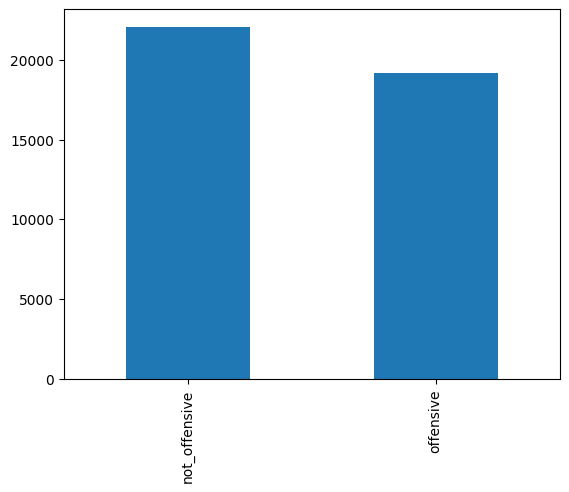

In [26]:
#plot distribution of label classes
twitter_df['label'].value_counts().plot(kind='bar')
plt.show()

In [27]:
balance_counts3= twitter_df.groupby('label')['label'].agg('count').values
balance_counts3

array([22050, 19190])

In [28]:
#word cloud
twitter_mask = np.array(Image.open('twitter_mask3.jpg')) #fetch image for word cloud

#initialize word cloud object
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)

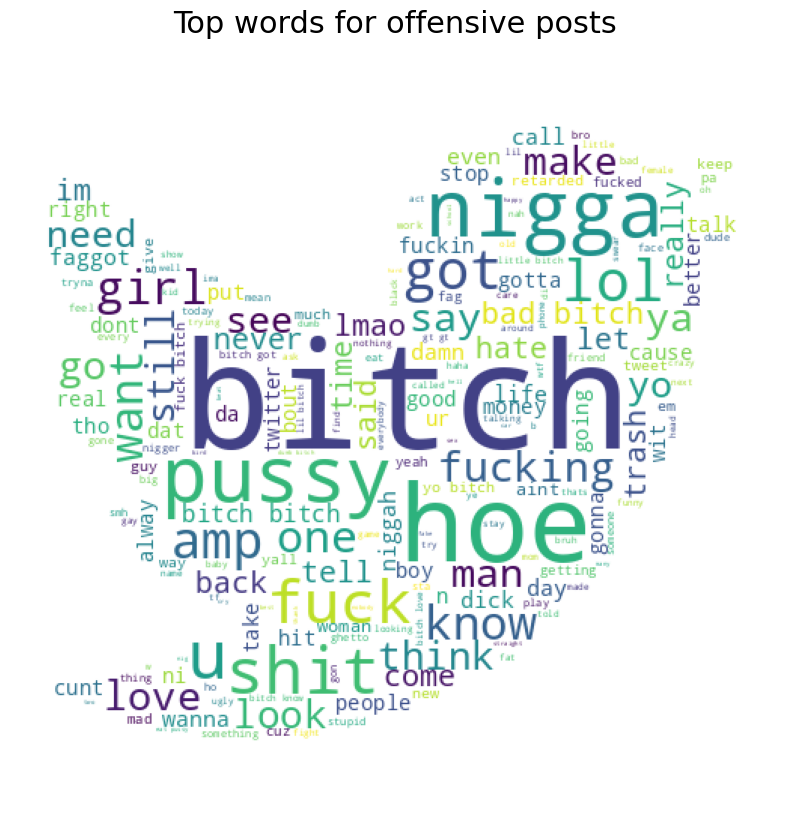

In [29]:
#visualize top words for offensive posts
wc.generate(' '.join(text for text in twitter_df.loc[twitter_df['label'] == 'offensive', 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for offensive posts', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

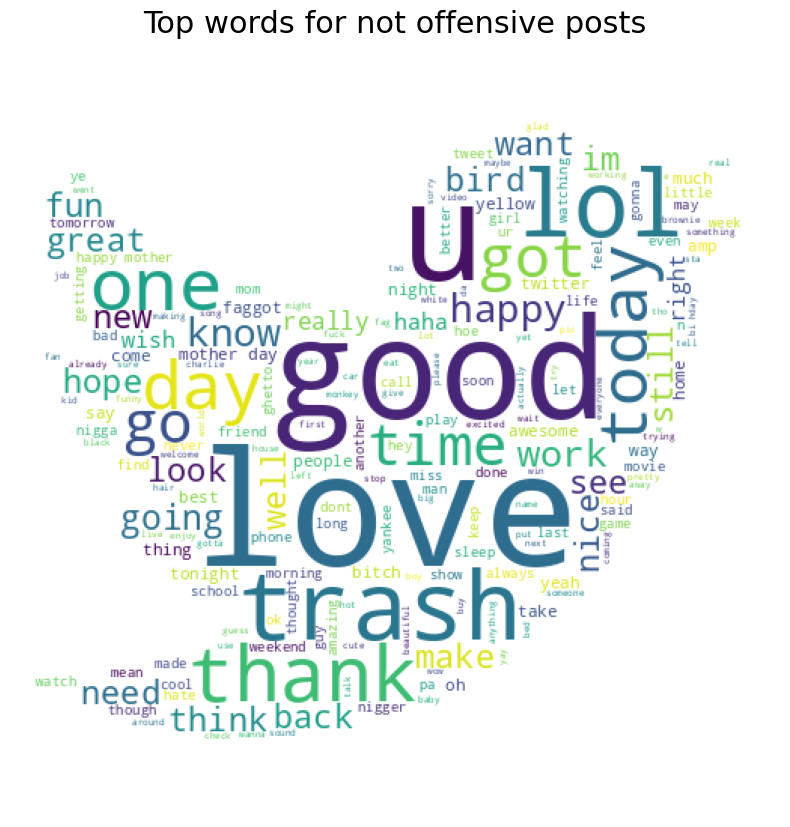

In [30]:
#visualize top words for not offensive posts
wc.generate(' '.join(text for text in twitter_df.loc[twitter_df['label'] != 'offensive', 'tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for not offensive posts', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [31]:
#label encode tweet labels into numerical values
le=LabelEncoder()
twitter_df.label=le.fit_transform(twitter_df.label)
twitter_df

,tweet,label,tweet_clean
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,woman complain cleaning house amp man always ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boy dat cold tyga dwn bad cuffin dat hoe place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,shit hear might true might faker bitch told ya
...,...,...,...
41235,having Bigi & Tokyo Fashion Spree tmr Check o...,0,bigi tokyo fashion spree tmr check sih web
41236,ha ha funny,0,ha ha funny
41237,Just watched the 'Final Break' final prison br...,0,watched final break final prison break episode...
41238,dam living in england,0,dam living england


In [32]:
#label classes
le.classes_

array(['not_offensive', 'offensive'], dtype=object)

---

# Preprocessing

The text data is vectorized. That is, text is represented by vectors to enable processing by the classification models. The vectorization was done using the below algorithms:
- Term Frequency Inverse Document Frequency (TFIDF)
- Word embeddings techniques:
    - word2vec
    - GloVe
    - FastText

## Term Frequency - Inverse Document Frequency (TFIDF)

TIDF takes into account the frequency of a term within a document (term frequency) and the frequency of the term across all documents in the collection (document frequency). The main idea behind TIDF is that a term is considered important if it appears frequently within a document and is relatively rare across the entire collection of documents. This is because terms that are common in a particular document but rare in the collection as a whole are considered indicative of the content or topic of that document.

TIDF is calculated using the following formula:

TIDF(term, document) = Term Frequency (TF) * log ( N / Document Frequency (DF) )

Where:
Term Frequency (TF)- frequency of a term within a document <br>
N- total number of documents in the collection <br>
Document Frequency (DF)- number of documents in the collection that contain the term <br>
log- natural logarithm <br>

In [ ]:
# Vectorize the text
tfidf_vectorizer = TfidfVectorizer()
tfidf_preprocesed = tfidf_vectorizer.fit_transform(twitter_df['tweet_clean'])

In [ ]:
tfidf_preprocesed

<41240x22584 sparse matrix of type '<class 'numpy.float64'>'
	with 243431 stored elements in Compressed Sparse Row format>

## Word Embeddings

Word embeddings are typically learned from large text corpora using unsupervised learning methods, such as word2vec, GloVe, or FastText. These methods leverage the distributional hypothesis, which posits that words that occur in similar contexts tend to have similar meanings. Word embeddings are learned by training a neural network on a large corpus of text data, which predicts the context of a word based on its neighboring words. The learned embeddings are then used to represent words as continuous vectors, where words with similar meanings or contextual usage tend to have similar vector representations.

In [ ]:
#word tokenization: split tweets into smaller units (words/tokens)
word_tokens = [word_tokenize(row) for row in twitter_df['tweet_clean']]
word_tokens[:3]

[['woman',
  'complain',
  'cleaning',
  'house',
  'amp',
  'man',
  'always',
  'take',
  'trash'],
 ['boy', 'dat', 'cold', 'tyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', 'place'],
 ['dawg', 'ever', 'fuck', 'bitch', 'sta', 'cry', 'confused', 'shit']]

### word2vec Technique

WordVecs are designed to capture the semantic meaning and syntactic relationships between words, allowing algorithms to understand the contextual meaning of words based on their position in the vector space.

In [ ]:
# define word2vec parameters
size = 100 #number of dimensions of the embeddings and the default is 100. default is 100
window = 3 #maximum distance between a target word and words around the target word. default is 5
min_count = 1 #minimum count of words to consider when training the model. default is 1
workers = 3 #number of partitions during training. default workers is 3
sg = 1 #training algorithm, either CBOW(0) or skip gram(1). default is 1

In [ ]:
# Train the Word2Vec Model on corpus
w2v_model = Word2Vec(word_tokens,
                     min_count = min_count,
                     vector_size = size,
                     workers = workers,
                     window = window,
                     sg = sg)

In [ ]:
# Unique ID of the word
print("Index of the word 'woman':")
print(w2v_model.wv.key_to_index["woman"])

Index of the word 'woman':
135


In [ ]:
#get the embedding of word: woman
w2v_model.wv.get_vector('woman')

array([-0.03757146,  0.12919547, -0.07610048,  0.26406917,  0.1432061 ,
       -0.31649184,  0.4061167 ,  0.6666469 , -0.15957238, -0.38585624,
        0.04462668, -0.45290205, -0.02935861,  0.3822323 ,  0.09195297,
       -0.00392013,  0.4366886 , -0.07470508, -0.33136806, -0.65420073,
        0.20981386,  0.07984793,  0.19775657, -0.2388702 , -0.02143029,
       -0.03669062, -0.12042373, -0.07403408,  0.01138433,  0.13176632,
        0.31194264,  0.02991057,  0.35984117, -0.47615495, -0.16067547,
        0.3483508 ,  0.28836885, -0.11757296, -0.02755575, -0.46144396,
        0.20799294, -0.1441211 , -0.18456551, -0.15658692,  0.34868953,
        0.11276996, -0.2641476 , -0.05487837,  0.20828333,  0.1593543 ,
        0.11269971, -0.23032896, -0.2893379 , -0.06085562, -0.21621172,
        0.17835741,  0.26579878, -0.2629187 , -0.32055604,  0.2648019 ,
       -0.02007949,  0.04380845,  0.36049348,  0.0080883 , -0.37034735,
        0.27067366, -0.08900793,  0.41259325, -0.5534848 ,  0.35

In [ ]:
#sample similar words: bitch
w2v_model.wv.similar_by_word("bitch")

[('hoe', 0.9168019890785217),
 ('niggah', 0.904712975025177),
 ('nigga', 0.8821009397506714),
 ('ni', 0.8779774904251099),
 ('faggot', 0.8722697496414185),
 ('em', 0.865990936756134),
 ('fag', 0.8487271070480347),
 ('nigguh', 0.8448464870452881),
 ('yo', 0.8354721069335938),
 ('bruh', 0.834815263748169)]

In [ ]:
#sample similar words: love
w2v_model.wv.similar_by_word("love")

[('calling', 0.9428398609161377),
 ('made', 0.9330622553825378),
 ('called', 0.9321229457855225),
 ('thanks', 0.9314947724342346),
 ('met', 0.9312858581542969),
 ('mine', 0.9292632937431335),
 ('though', 0.928890585899353),
 ('girlfriend', 0.9281972646713257),
 ('thought', 0.9263433814048767),
 ('relationship', 0.9254710674285889)]

In [ ]:
# Total number of the words 
print(len(w2v_model.wv.key_to_index))

22597


In [ ]:
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(w2v_model.wv['bitch']))

Length of the vector generated for a word
100


In [ ]:
# total number of extracted words.
vocab=w2v_model.wv.key_to_index
print("The total number of words are : ",len(vocab))

The total number of words are :  22597


In [ ]:
# view samples of the vocabulary
vocab=list(vocab.keys())
vocab[:12]

['bitch',
 'hoe',
 'like',
 'pussy',
 'get',
 'got',
 'nigga',
 'u',
 'as',
 'lol',
 'love',
 'good']

In [ ]:
#create dictionary of the vocabulary
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  22597


In [ ]:
#view vector of word: love
word_vec_dict['love']

array([-0.07227783,  0.18340494, -0.03651408, -0.05295954,  0.0514714 ,
       -0.37652075,  0.22643006,  0.7907296 ,  0.06407717, -0.3605858 ,
        0.09873192, -0.60969704, -0.16814181,  0.19688256,  0.13678698,
       -0.05245375,  0.4549145 , -0.33437458, -0.321556  , -0.76618564,
        0.17282444,  0.01591177,  0.34310395, -0.49785063, -0.14335614,
        0.14523551, -0.14208537, -0.07290777,  0.05280511,  0.15214595,
        0.46778283,  0.10481016,  0.3161022 , -0.3859987 , -0.17295797,
        0.25042304,  0.2706566 , -0.1937287 ,  0.16115153, -0.5913468 ,
        0.0893437 , -0.12302785, -0.11902642, -0.15006751,  0.06593093,
       -0.13799983, -0.19378716, -0.03376313, -0.06052056,  0.31426427,
        0.21104749, -0.211922  ,  0.05303325,  0.12540273, -0.1483236 ,
        0.20809056,  0.18132165, -0.22695361, -0.41680697,  0.29791784,
       -0.13357842,  0.11755499,  0.35818925,  0.06420293, -0.43086934,
        0.4946688 ,  0.02956193,  0.3861241 , -0.6877275 ,  0.26

In [ ]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
size = 100
embedding_matrix_w2v = np.zeros((len(vocab), size))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(vocab):
    if word in word_vec_dict:
        embedding_matrix_w2v[i] = word_vec_dict[word]
    else:
        # If the word is not in the word2vec vocab dictionary, use a random initialization
        embedding_matrix_w2v[i] = np.random.rand(size)

In [ ]:
#embedding matrix
embedding_matrix_w2v

array([[-0.2002186 ,  0.09630782,  0.17691842, ..., -0.7020312 ,
        -0.16927552,  0.38126805],
       [-0.15179709,  0.04704688,  0.18433072, ..., -0.66274899,
        -0.30699423,  0.29792914],
       [-0.00501625,  0.26546556, -0.21776952, ..., -0.29441237,
         0.17096163, -0.03428898],
       ...,
       [-0.00661843,  0.00757978, -0.0096613 , ..., -0.04566362,
         0.00278437,  0.02764647],
       [-0.01678175,  0.01478761,  0.00223413, ..., -0.04356202,
        -0.00686306,  0.02484581],
       [-0.0234865 ,  0.01479038,  0.00104343, ..., -0.05274286,
        -0.01949681,  0.02806809]])

In [ ]:
#embedding matrix shape
embedding_matrix_w2v.shape

(22597, 100)

In [ ]:
# Convert the text data into numerical sequences using Word2Vec where values are the keys to the word2vec dictionary
num_sequences_w2v = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in w2v_model.wv.key_to_index.keys():
            num_sequence.append(w2v_model.wv.key_to_index[word])
    num_sequences_w2v.append(num_sequence)

In [ ]:
#view first record in sequence
num_sequences_w2v[0]

[135, 1231, 1030, 208, 21, 38, 89, 62, 18]

In [ ]:
#length of sequence: same as dataframe records
len(num_sequences_w2v)

41240

In [ ]:
#maximum length in the sequence
max_sequence_length = max(len(sequence) for sequence in num_sequences_w2v)  # max lenght of a tweet/text
max_sequence_length

28

In [ ]:
# now padding to have a maximum length of 28
pad_tweets_w2v= pad_sequences(num_sequences_w2v, maxlen=max_sequence_length, padding='post')
pad_tweets_w2v.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [ ]:
len(pad_tweets_w2v[0])

28

In [ ]:
pad_tweets_w2v[0]

array([ 135, 1231, 1030,  208,   21,   38,   89,   62,   18,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

### GloVe Technique

GloVe word embeddings are pre-trained on large text corpora and learn to represent words based on their co-occurrence statistics in the training data. The idea behind GloVe is that words that have similar meanings or are used in similar contexts tend to occur together frequently in text. GloVe embeddings leverage this observation by learning word vectors that capture the distributional properties of words in the context of their co-occurring words.
One of the main advantages of GloVe embeddings is that they are able to capture both syntactic and semantic relationships between words.

In [ ]:
#load pretrained model
glove_model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
# Unique ID of the word
print("Index of the word 'woman':")
print(glove_model.key_to_index["woman"])

Index of the word 'woman':
1240


In [ ]:
#get the embedding of word: woman
glove_model['woman']

array([ 0.35761  , -0.55737  , -0.29762  ,  0.56073  , -0.3983   ,
       -0.21551  ,  0.59801  ,  0.13016  ,  0.60363  , -0.4305   ,
       -0.3259   ,  0.096317 , -4.1119   , -0.27945  ,  0.21279  ,
        0.28401  ,  0.26991  , -0.65553  ,  0.48464  ,  0.18451  ,
        1.0443   , -0.069635 , -0.098869 , -0.016446 , -0.25633  ,
        0.55831  , -0.50894  , -0.16896  , -0.6802   ,  0.49299  ,
        0.83425  , -0.4249   , -0.16513  ,  0.66931  ,  0.38609  ,
        0.47012  , -0.026249 ,  0.19812  , -0.3473   ,  0.034589 ,
       -0.25654  ,  0.26041  ,  0.45436  ,  0.061987 ,  0.79604  ,
        0.3097   ,  0.61956  ,  0.50329  , -0.12585  , -0.0071808,
       -0.83839  ,  0.29762  , -0.35479  , -0.50594  , -0.16857  ,
        0.062532 , -0.31103  ,  0.086456 , -0.66457  ,  0.80991  ,
        0.037768 ,  0.70021  ,  0.26671  , -0.33556  ,  0.3361   ,
        0.16335  ,  0.048709 , -0.16753  ,  0.32006  ,  0.2376   ,
       -0.01335  , -0.73784  ,  0.33628  , -0.70988  ,  0.3347

In [ ]:
#sample similar words: woman
glove_model.most_similar('woman')

[('women', 0.8050916194915771),
 ('girl', 0.7974741458892822),
 ('wife', 0.7853384017944336),
 ('mother', 0.7815033793449402),
 ('person', 0.7773492932319641),
 ('female', 0.7678147554397583),
 ('guy', 0.7642642259597778),
 ('she', 0.7594019174575806),
 ('daughter', 0.740329921245575),
 ('child', 0.736954927444458)]

In [ ]:
# total number of extracted words
vocab_glove=glove_model.key_to_index
print("The total number of words are : ",len(vocab_glove))

The total number of words are :  1193514


In [ ]:
#create dictionary of the vocabulary
glove_dict={}
for word in vocab_glove:
    glove_dict[word]=glove_model.get_vector(word)
print("The no of key-value pairs : ",len(glove_dict)) # should come equal to vocab size

The no of key-value pairs :  1193514


In [ ]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
embedding_dim = 100
embedding_matrix_glove = np.zeros((len(vocab_glove), embedding_dim))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(vocab_glove):
    if word in glove_dict:
        embedding_matrix_glove[i] = glove_dict[word]
    else:
        # If the word is not in the GloVe vocab dictionary, use a random initialization
        embedding_matrix_glove[i] = np.random.rand(embedding_dim)

In [ ]:
#embedding matrix
embedding_matrix_glove

array([[ 0.63006002,  0.65177   ,  0.25545001, ...,  0.55096   ,
         0.64705998, -0.60930002],
       [ 0.18205   , -0.048483  ,  0.23965999, ..., -0.33579999,
         0.18884   , -0.40786001],
       [ 1.06739998,  0.45716   ,  0.51463002, ...,  0.13974001,
         0.76486999, -0.17314   ],
       ...,
       [ 0.28891999,  0.25407001,  0.11113   , ..., -0.61580002,
         0.046846  , -0.086387  ],
       [-0.38313001,  0.064609  ,  0.27384001, ..., -0.16395999,
        -0.26971   , -0.69941002],
       [-0.028777  , -0.72606999, -0.82770002, ..., -0.69694   ,
        -0.76516998, -1.09010005]])

In [ ]:
#embedding matrix
embedding_matrix_glove.shape

(1193514, 100)

In [ ]:
# Convert the text data into numerical sequences using GloVe where values are the keys to the GloVe dictionary
num_sequences_glove = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in glove_model:
            num_sequence.append(glove_model.key_to_index[word])
    num_sequences_glove.append(num_sequence)

In [ ]:
#view first record in sequence
num_sequences_glove[0]

[1240, 5032, 5639, 543, 12800, 246, 245, 284, 6740]

In [ ]:
#length of sequence: same as dataframe records
len(num_sequences_glove)

41240

In [ ]:
#maximum length in the sequence
max_sequence_length=max(len(sequence) for sequence in num_sequences_glove)
max_sequence_length

28

In [ ]:
# now padding to have a maximum length of 28
pad_tweets_glove= pad_sequences(num_sequences_glove, maxlen=max_sequence_length, padding='post')
pad_tweets_glove.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [ ]:
pad_tweets_glove[0]

array([ 1240,  5032,  5639,   543, 12800,   246,   245,   284,  6740,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

### FastText Technique

FastText uses a combination of traditional natural language processing (NLP) techniques and machine learning algorithms to represent words and text as continuous vectors. One of the key features of FastText is its ability to handle out-of-vocabulary (OOV) words, which are words that do not appear in the training data. 

In [ ]:
# Train FastText model on training data
fasttext_model =FastText(vector_size=100, window=3, min_count=1) # instantiate
fasttext_model.build_vocab(corpus_iterable=word_tokens)
fasttext_model.train(corpus_iterable=word_tokens, total_examples=len(word_tokens), epochs=10)  # train

(2293620, 2572430)

In [ ]:
# Unique ID of the word
print("Index of the word 'love':")
print(fasttext_model.wv.get_index('love'))

Index of the word 'love':
10


In [ ]:
#get the embedding of word: love
fasttext_model.wv.get_vector('love')

array([-0.45358676,  0.19461626, -0.50421757,  0.57938015,  0.43929052,
        0.4681036 ,  0.01700431,  0.5414123 ,  0.7293648 , -0.6357615 ,
        0.09903371,  0.08149969, -0.18227023,  0.7927988 ,  0.35499057,
       -0.2603587 ,  0.4242897 , -0.11615167, -0.56217766, -1.0701393 ,
       -0.8721249 ,  0.56321293,  0.34788457, -0.5143971 , -0.34311017,
       -0.28811076,  0.21629626,  0.23408483,  1.106527  ,  0.21520662,
       -0.16557586, -0.35279354,  0.48717195, -0.07364473, -0.10943358,
        0.27939013,  0.61681485,  0.9365507 , -0.45793954,  0.674581  ,
        0.5875315 , -0.16459228, -0.24833967, -0.2734141 , -0.21079774,
       -0.14849202, -0.8080505 , -0.29661366,  0.17231034,  0.15682076,
        0.26711226, -0.0415768 ,  0.8302582 ,  0.5419523 , -0.88267463,
       -0.2922063 , -0.39687347,  0.4142913 , -0.47500074,  0.52679265,
       -0.50539094,  0.02197965, -0.83281404,  0.75977343, -0.16841966,
        1.4989747 , -0.13069883,  0.10756796, -0.17681444,  0.09

In [ ]:
#sample similar words: love
fasttext_model.wv.most_similar('love')

[('loveeya', 0.9935050010681152),
 ('loveu', 0.9903830289840698),
 ('lovebug', 0.9885424971580505),
 ('lovesu', 0.9868307113647461),
 ('ylove', 0.9843373894691467),
 ('lovelovelove', 0.9809839725494385),
 ('lovey', 0.9797903299331665),
 ('lovve', 0.9778053760528564),
 ('ilove', 0.9759315848350525),
 ('lovee', 0.9749712944030762)]

In [ ]:
# total number of extracted words
vocab_fasttext=fasttext_model.wv.key_to_index
print("The total number of words are : ",len(vocab_fasttext))

The total number of words are :  22597


In [ ]:
#create dictionary of the vocabulary
fasttext_dict={}
for word in vocab_fasttext.keys():
    fasttext_dict[word]=fasttext_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(fasttext_dict)) # should come equal to vocab size

The no of key-value pairs :  22597


In [ ]:
# Create an embedding_matrix with shape (vocab_size, embedding_dim)
size = 100
embedding_matrix_fasttext = np.zeros((len(vocab_fasttext), size))

# Fill in the embedding_matrix with the corresponding embeddings
for i, word in enumerate(fasttext_dict.keys()):
    if word in fasttext_dict:
        embedding_matrix_fasttext[i] = fasttext_dict[word]
    else:
        # If the word is not in the word2vec vocab dictionary, use a random initialization
        embedding_matrix_fasttext[i] = np.random.rand(size)

In [ ]:
# Convert the text data into numerical sequences using Fasttext where values are the keys to the word2vec dictionary
num_sequences_fasttext = [] 

for row in twitter_df['tweet_clean']:
    num_sequence = []
    for word in row.split():
        if word in fasttext_model.wv.key_to_index.keys():
            num_sequence.append(fasttext_model.wv.key_to_index[word])
    num_sequences_fasttext.append(num_sequence)

In [ ]:
#view first record in sequence
num_sequences_fasttext[0]

[135, 1231, 1030, 208, 21, 38, 89, 62, 18]

In [ ]:
#maximum length in the sequence
max_sequence_length = max(len(sequence) for sequence in num_sequences_fasttext)  # max lenght of a tweet/text
max_sequence_length

28

In [ ]:
# now padding to have a maximum length of 28
pad_tweets_fasttext= pad_sequences(num_sequences_fasttext, maxlen=max_sequence_length, padding='post')
pad_tweets_fasttext.shape   # note that we had 41240 tweets and we have padded each review to have  a lenght of 28 words.

(41240, 28)

In [ ]:
pad_tweets_fasttext[0]

array([ 135, 1231, 1030,  208,   21,   38,   89,   62,   18,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

---

# Model Building

The classification models' architecture is designed here and fitted on training data. The below models were used in this research.

- Support Vector Machine (SVM): The baseline model
- Bidirectional Long short-term memory (BiLSTM)
- Bidirectional Encoder Representations from Transformers (BERT) 

In [39]:
#define hyperparameters
dropout=0.2
num_classes = 2
learning_rate_rnn = 0.001
learning_rate_bert=3e-5
batch_size = 64
epochs = 20
steps_per_epoch=100

## SVM

Support Vector Machines (SVM) is a popular machine learning algorithm used for classification and regression tasks. It is a supervised learning algorithm that can be used for both binary and multi-class classification. SVM works by finding the optimal hyperplane that best separates the data into different classes, maximizing the margin between the classes.

In [ ]:
#split data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(tfidf_preprocesed, twitter_df['label'], test_size=0.2, random_state=42)


In [ ]:
#initialize model
svm_model = SVC(C=1.0, kernel='linear')

#train model
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

## Recurrent Neural Network Architecture: BiLSTM

Bidirectional Long Short-Term Memory (BiLSTM) is a type of recurrent neural network (RNN) architecture that is commonly used for sequential data processing tasks, such as natural language processing (NLP) and speech recognition. It is an extension of the traditional Long Short-Term Memory (LSTM) architecture, which is a type of RNN that is designed to capture long-term dependencies in sequential data.


The key difference between a standard LSTM and a BiLSTM is that a BiLSTM processes input data in both forward and backward directions, allowing it to capture information from both past and future context. This makes BiLSTM particularly effective in tasks where the context in both directions is important, such as sequence labeling tasks, where each element in a sequence needs to be labeled based on its context.

In [ ]:
# prepare data for model
y=tf.keras.utils.to_categorical(twitter_df['label'])  # one hot target as required by neural network.
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
#split w2v embedded data into train and test dataset
x_train1,x_test1,y_train1,y_test1=train_test_split(pad_tweets_w2v,y,test_size=0.20,random_state=42)

In [ ]:
#split glove embedded data into train and test dataset
x_train2,x_test2,y_train2,y_test2=train_test_split(pad_tweets_glove,y,test_size=0.20,random_state=42)

In [ ]:
#split glove embedded data into train and test dataset
x_train3,x_test3,y_train3,y_test3=train_test_split(pad_tweets_fasttext,y,test_size=0.20,random_state=42)

In [ ]:
# Define the hyperparameters
vocab_size_w2v = len(w2v_model.wv.key_to_index) # total no of words w2v
vocab_size_glove = len(glove_model.key_to_index) # total no of words glove
vocab_size_fasttext = len(fasttext_model.wv.key_to_index) # total no of words fasttext
embed_dim_w2v=w2v_model.vector_size # embedding dimension as choosen in word2vec constructor
embed_dim_glove=glove_model.vector_size # embedding dimension as choosen in Glove constructor
embed_dim_fasttext=fasttext_model.vector_size # embedding dimension as choosen in Glove constructor

In [ ]:
print(f'vocab size w2v:{vocab_size_w2v}')
print(f'vocab size glove:{vocab_size_glove}')
print(f'vocab size fasttext:{vocab_size_fasttext}')
print(f'embed dim w2v:{embed_dim_w2v}')
print(f'embed dim glove:{embed_dim_glove}')
print(f'embed dim fasttext:{embed_dim_fasttext}')
print(f'max sequence length:{max_sequence_length}')

vocab size w2v:22563
vocab size glove:1193514
vocab size fasttext:22563
embed dim w2v:100
embed dim glove:100
embed dim fasttext:100
max sequence length:28


### word2vec + LSTM

In [ ]:
# define the model architecture :LSTM
lstm1 = Sequential()
lstm1.add(Embedding(input_dim=vocab_size_w2v, output_dim=embed_dim_w2v, weights=[embedding_matrix_w2v], input_length=max_sequence_length, trainable=False))
lstm1.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)))
lstm1.add(Bidirectional(LSTM(units=256, dropout=dropout, recurrent_dropout=dropout)))
lstm1.add(Dense(units=512, activation='relu'))
lstm1.add(Dropout(dropout))
lstm1.add(Dense(units=num_classes, activation='softmax'))

lstm1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate_rnn),loss='categorical_crossentropy',metrics=['accuracy'])
lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 100)           2256300   
                                                                 
 bidirectional (Bidirectiona  (None, 28, 256)          234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

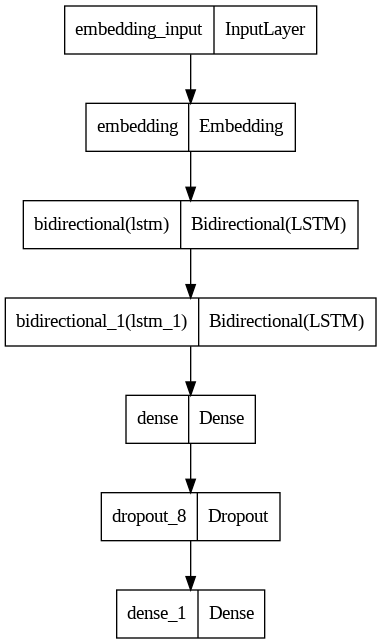

In [ ]:
tf.keras.utils.plot_model(lstm1, to_file="lstm1.png")

In [ ]:
#Call back setup
es = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=3,verbose=1)
cb = [es]

In [ ]:
# fitting the model
lstm_hist1=lstm1.fit(x_train1,y_train1,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test1,y_test1))

Epoch 1/20
100/100 [==============================] - 115s 1s/step - loss: 0.5728 - accuracy: 0.6902 - val_loss: 0.4937 - val_accuracy: 0.7677
Epoch 2/20
100/100 [==============================] - 105s 1s/step - loss: 0.4321 - accuracy: 0.8191 - val_loss: 0.3462 - val_accuracy: 0.8640
Epoch 3/20
100/100 [==============================] - 105s 1s/step - loss: 0.3725 - accuracy: 0.8536 - val_loss: 0.3230 - val_accuracy: 0.8745
Epoch 4/20
100/100 [==============================] - 103s 1s/step - loss: 0.3788 - accuracy: 0.8525 - val_loss: 0.3051 - val_accuracy: 0.8820
Epoch 5/20
100/100 [==============================] - 104s 1s/step - loss: 0.3238 - accuracy: 0.8755 - val_loss: 0.3117 - val_accuracy: 0.8755
Epoch 6/20
100/100 [==============================] - 105s 1s/step - loss: 0.3240 - accuracy: 0.8761 - val_loss: 0.2976 - val_accuracy: 0.8877
Epoch 7/20
100/100 [==============================] - 105s 1s/step - loss: 0.3165 - accuracy: 0.8786 - val_loss: 0.3093 - val_accuracy: 0.8814

### GloVe + LSTM

In [ ]:
# Define the model architecture
lstm2 = Sequential()
lstm2.add(Embedding(input_dim=vocab_size_glove, output_dim=embed_dim_glove, weights=[embedding_matrix_glove], input_length=max_sequence_length, trainable=False))
lstm2.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)))
lstm2.add(Bidirectional(LSTM(units=256, dropout=dropout, recurrent_dropout=dropout)))
lstm2.add(Dense(units=512, activation='relu'))
lstm2.add(Dropout(dropout))
lstm2.add(Dense(units=num_classes, activation='softmax'))

lstm2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate_rnn),loss='categorical_crossentropy',metrics=['accuracy'])
lstm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 100)           119351400 
                                                                 
 bidirectional_2 (Bidirectio  (None, 28, 256)          234496    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                

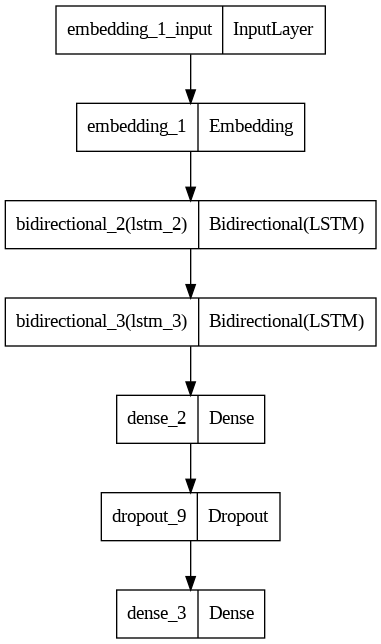

In [ ]:
tf.keras.utils.plot_model(lstm2, to_file="lstm2.png")

In [ ]:
#Call back setup
es = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=3,verbose=1)
cb = [es]

In [ ]:
# fitting the model.
lstm_hist2=lstm2.fit(x_train2,y_train2,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test2,y_test2))

Epoch 1/20
100/100 [==============================] - 116s 1s/step - loss: 0.3061 - accuracy: 0.8687 - val_loss: 0.2027 - val_accuracy: 0.9287
Epoch 2/20
100/100 [==============================] - 104s 1s/step - loss: 0.1960 - accuracy: 0.9295 - val_loss: 0.1886 - val_accuracy: 0.9305
Epoch 3/20
100/100 [==============================] - 105s 1s/step - loss: 0.1914 - accuracy: 0.9283 - val_loss: 0.1769 - val_accuracy: 0.9316
Epoch 4/20
100/100 [==============================] - 105s 1s/step - loss: 0.1768 - accuracy: 0.9359 - val_loss: 0.1774 - val_accuracy: 0.9354
Epoch 5/20
100/100 [==============================] - 103s 1s/step - loss: 0.1805 - accuracy: 0.9312 - val_loss: 0.1564 - val_accuracy: 0.9410
Epoch 6/20
100/100 [==============================] - 105s 1s/step - loss: 0.1593 - accuracy: 0.9399 - val_loss: 0.1621 - val_accuracy: 0.9348
Epoch 7/20
100/100 [==============================] - 105s 1s/step - loss: 0.1536 - accuracy: 0.9467 - val_loss: 0.1675 - val_accuracy: 0.9423

### FastText + LSTM

In [ ]:
# Define the model architecture
lstm3 = Sequential()
lstm3.add(Embedding(input_dim=vocab_size_fasttext, output_dim=embed_dim_fasttext, weights=[embedding_matrix_fasttext], input_length=max_sequence_length, trainable=False))
lstm3.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=dropout, recurrent_dropout=dropout)))
lstm3.add(Bidirectional(LSTM(units=256, dropout=dropout, recurrent_dropout=dropout)))
lstm3.add(Dense(units=512, activation='relu'))
lstm3.add(Dropout(dropout))
lstm3.add(Dense(units=num_classes, activation='softmax'))

lstm3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate_rnn),loss='categorical_crossentropy',metrics=['accuracy'])
lstm3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 100)           2256300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 28, 256)          234496    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                

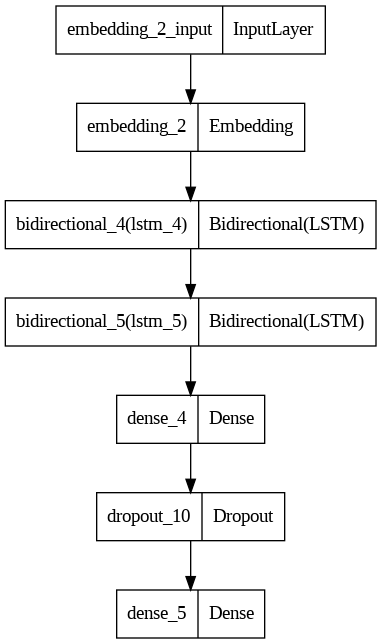

In [ ]:
tf.keras.utils.plot_model(lstm3)

In [ ]:
#Call back setup
es = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=3,verbose=1)
cb = [es]

In [ ]:
# fitting the model.
lstm_hist3=lstm3.fit(x_train3,y_train3,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test3,y_test3))

Epoch 1/20
100/100 [==============================] - 116s 1s/step - loss: 0.5479 - accuracy: 0.7233 - val_loss: 0.4067 - val_accuracy: 0.8368
Epoch 2/20
100/100 [==============================] - 105s 1s/step - loss: 0.3881 - accuracy: 0.8461 - val_loss: 0.3457 - val_accuracy: 0.8601
Epoch 3/20
100/100 [==============================] - 105s 1s/step - loss: 0.3656 - accuracy: 0.8536 - val_loss: 0.3341 - val_accuracy: 0.8758
Epoch 4/20
100/100 [==============================] - 104s 1s/step - loss: 0.3389 - accuracy: 0.8722 - val_loss: 0.3153 - val_accuracy: 0.8828
Epoch 5/20
100/100 [==============================] - 105s 1s/step - loss: 0.3351 - accuracy: 0.8698 - val_loss: 0.3122 - val_accuracy: 0.8807
Epoch 6/20
100/100 [==============================] - 105s 1s/step - loss: 0.3117 - accuracy: 0.8791 - val_loss: 0.3018 - val_accuracy: 0.8790
Epoch 7/20
100/100 [==============================] - 104s 1s/step - loss: 0.3181 - accuracy: 0.8808 - val_loss: 0.3077 - val_accuracy: 0.8846

## BERT
BERT utilizes attention mechanism (transformer) to learn the contextual meaning of words relative to the sentence they are used in when generating word embeddings, rather than just looking at the preceding or following words as traditional NLP models do. 

In [ ]:
#prepare data for model
tweets_data = twitter_df['tweet_clean'].to_numpy()
tweet_label = tf.keras.utils.to_categorical(twitter_df['label'])

In [ ]:
#split data into train and test dataset
x_train4,x_test4,y_train4,y_test4=train_test_split(tweets_data,tweet_label,test_size=0.20,random_state=42)

In [36]:
#preprocessing model
tfhub_handle_preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

#encoder model
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [34]:
#define model
def build_classifier_model():
  text_input = Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_preprocessor')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = Dropout(dropout)(net)
  net = Dense(512, activation='relu', name='Dense_layer')(net)
  net = Dropout(dropout)(net)
  net = Dense(2, activation='softmax', name='classifier')(net)
  return Model(text_input, net)

In [40]:
#instantiate and compile model
bert = build_classifier_model()
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate_bert),loss='categorical_crossentropy',metrics=['accuracy'])
bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 BERT_preprocessor (KerasLayer)  {'input_mask': (Non  0          ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

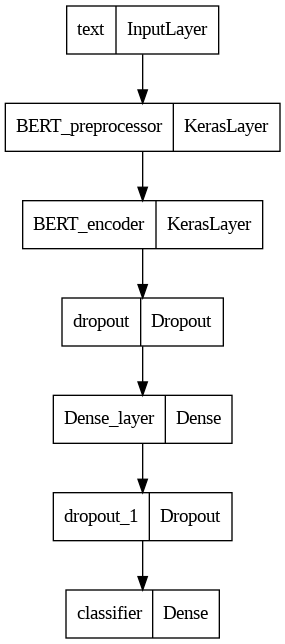

In [42]:
tf.keras.utils.plot_model(bert, to_file="bert.png")

In [ ]:
#Call back setup
es = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=3,verbose=1)
cb = [es]

In [ ]:
# fitting the model.
bert_hist=bert.fit(x_train4,y_train4,epochs=epochs,steps_per_epoch=steps_per_epoch,batch_size=batch_size,callbacks=cb,validation_data=(x_test4,y_test4))

Epoch 1/20
100/100 [==============================] - 64s 555ms/step - loss: 0.5949 - accuracy: 0.6794 - val_loss: 0.4973 - val_accuracy: 0.7653
Epoch 2/20
100/100 [==============================] - 52s 528ms/step - loss: 0.5157 - accuracy: 0.7486 - val_loss: 0.4469 - val_accuracy: 0.8013
Epoch 3/20
100/100 [==============================] - 52s 526ms/step - loss: 0.4857 - accuracy: 0.7650 - val_loss: 0.4203 - val_accuracy: 0.8126
Epoch 4/20
100/100 [==============================] - 52s 526ms/step - loss: 0.4509 - accuracy: 0.7950 - val_loss: 0.3978 - val_accuracy: 0.8253
Epoch 5/20
100/100 [==============================] - 52s 525ms/step - loss: 0.4304 - accuracy: 0.8062 - val_loss: 0.3858 - val_accuracy: 0.8327
Epoch 6/20
100/100 [==============================] - 52s 525ms/step - loss: 0.4240 - accuracy: 0.8109 - val_loss: 0.3752 - val_accuracy: 0.8361
Epoch 7/20
100/100 [==============================] - 52s 524ms/step - loss: 0.4127 - accuracy: 0.8169 - val_loss: 0.3696 - val_ac

# Performance Evaluation

The models are evaluated using Accuracy, Precision, Recall and F1-score metrics

In [ ]:
labels = le.classes_
labels

array(['not_offensive', 'offensive'], dtype=object)

In [ ]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## SVM

In [ ]:
#get prediction
y_pred = svm_model.predict(X_test)

In [ ]:
#generate classification report
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.93      0.96      0.94      4434
    offensive       0.95      0.92      0.93      3814

     accuracy                           0.94      8248
    macro avg       0.94      0.94      0.94      8248
 weighted avg       0.94      0.94      0.94      8248



confusion matrix, without Normalized
[[4250  184]
 [ 319 3495]]


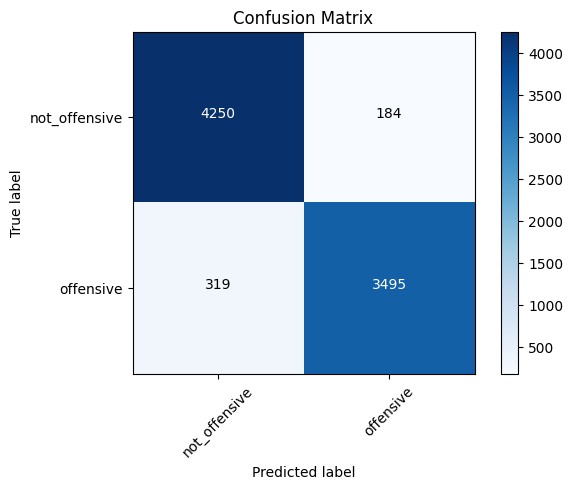

In [ ]:
#confusion matrix
svm_cm =confusion_matrix(y_test, y_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=svm_cm, classes=labels)

## Deep Neural Network Models

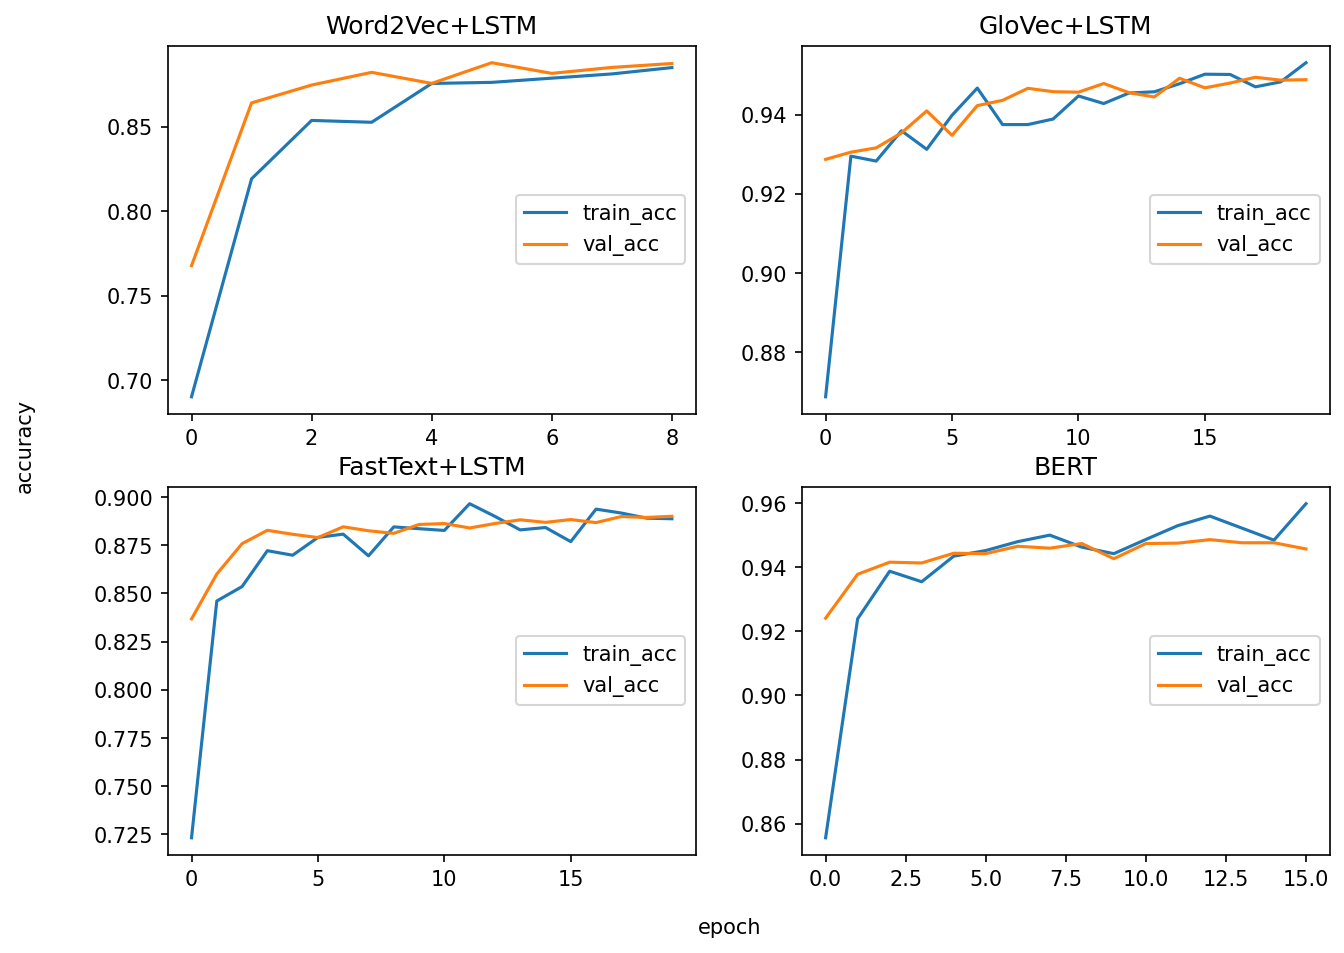

In [ ]:
#plot train and validation accuracy across epochs
fig = plt.figure(dpi=150, figsize = (10,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(lstm_hist1.history['accuracy'], label='train_acc')
ax1.plot(lstm_hist1.history['val_accuracy'], label = 'val_acc')
ax1.legend(loc='center right')
ax2.plot(lstm_hist2.history['accuracy'], label='train_acc')
ax2.plot(lstm_hist2.history['val_accuracy'], label = 'val_acc')
ax2.legend(loc='center right')
ax3.plot(lstm_hist3.history['accuracy'], label='train_acc')
ax3.plot(lstm_hist3.history['val_accuracy'], label = 'val_acc')
ax3.legend(loc='center right')
ax4.plot(bert_hist.history['accuracy'], label='train_acc')
ax4.plot(bert_hist.history['val_accuracy'], label = 'val_acc')
ax4.legend(loc='center right')


fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
fig.text(0.03, 0.5, 'accuracy', ha='center', va='center', rotation='vertical')

ax1.set_title('Word2Vec+LSTM')
ax2.set_title('GloVec+LSTM')
ax3.set_title('FastText+LSTM')
ax4.set_title('BERT')
plt.show()

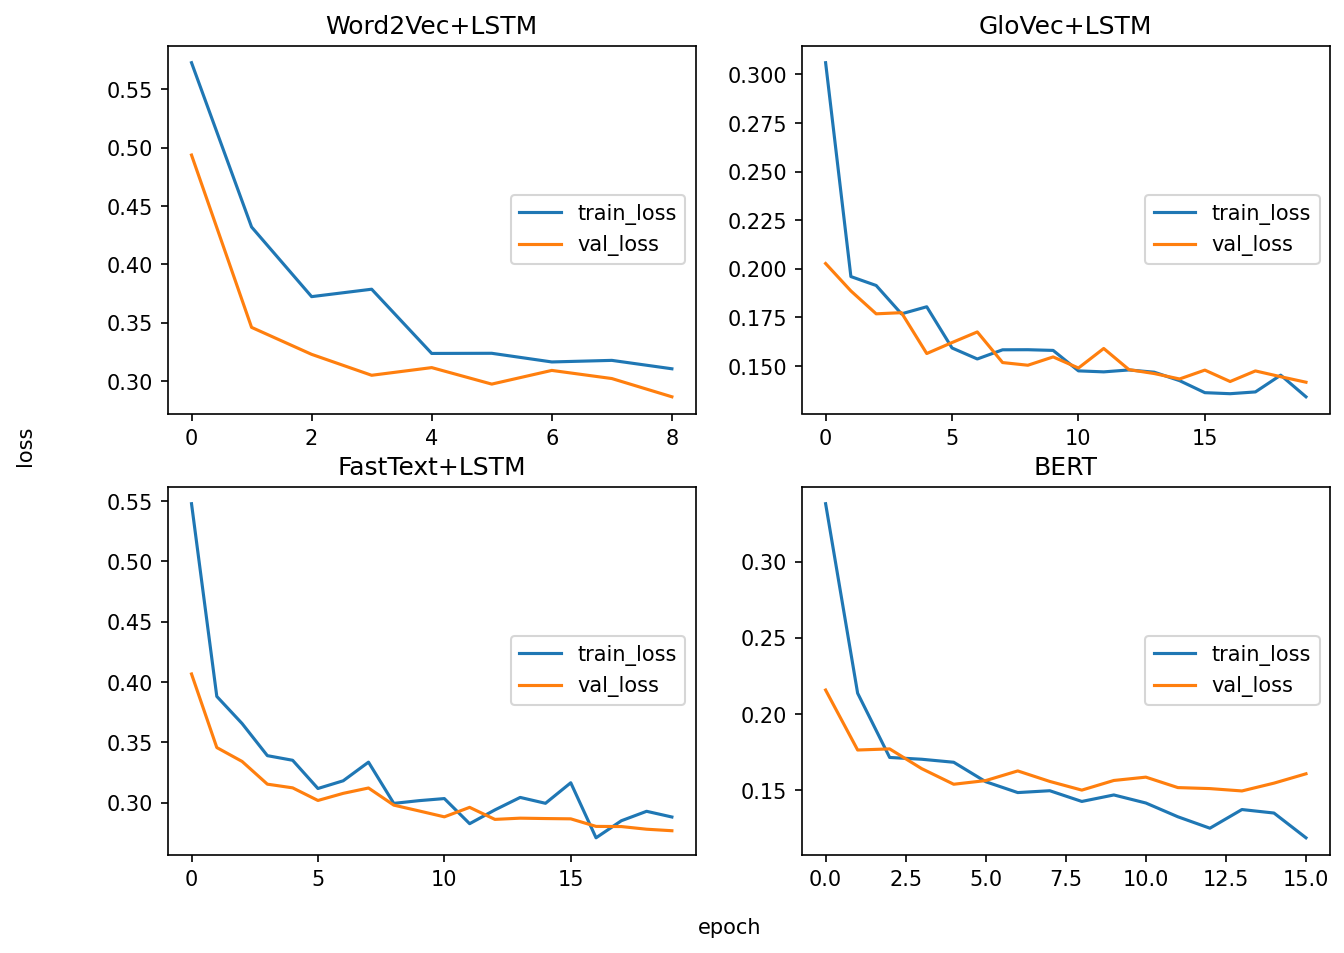

In [ ]:
#plot train and validation loss across epochs
fig = plt.figure(dpi=150, figsize = (10,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(lstm_hist1.history['loss'], label='train_loss')
ax1.plot(lstm_hist1.history['val_loss'], label = 'val_loss')
ax1.legend(loc='center right')
ax2.plot(lstm_hist2.history['loss'], label='train_loss')
ax2.plot(lstm_hist2.history['val_loss'], label = 'val_loss')
ax2.legend(loc='center right')
ax3.plot(lstm_hist3.history['loss'], label='train_loss')
ax3.plot(lstm_hist3.history['val_loss'], label = 'val_loss')
ax3.legend(loc='center right')
ax4.plot(bert_hist.history['loss'], label='train_loss')
ax4.plot(bert_hist.history['val_loss'], label = 'val_loss')
ax4.legend(loc='center right')

fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
fig.text(0.03, 0.5, 'loss', ha='center', va='center', rotation='vertical')

ax1.set_title('Word2Vec+LSTM')
ax2.set_title('GloVec+LSTM')
ax3.set_title('FastText+LSTM')
ax4.set_title('BERT')
plt.show()

### BiLSTM

In [ ]:
# model prediction: BiLSTM1
lstm1_pred = lstm1.predict(x=x_test1, verbose=0)

#get argmax of predictions
lstm1_pred = np.argmax(lstm1_pred, axis=1)

#get argmax of actuals
y_test_argmax =np.argmax(y_test1, axis=1)

In [ ]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm1_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.86      0.95      0.90      4434
    offensive       0.93      0.82      0.87      3814

     accuracy                           0.89      8248
    macro avg       0.89      0.88      0.89      8248
 weighted avg       0.89      0.89      0.89      8248



confusion matrix, without Normalized
[[4200  234]
 [ 696 3118]]


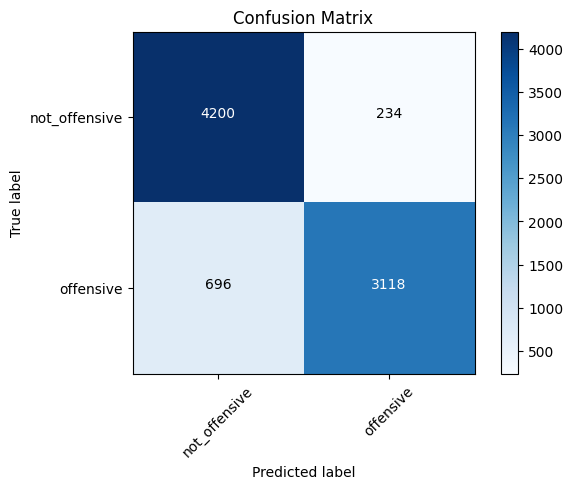

In [ ]:
#confusion matrix
lstm1_cm =confusion_matrix(y_test_argmax, lstm1_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm1_cm, classes=labels)

---

In [ ]:
# model prediction: BiLSTM2
lstm2_pred = lstm2.predict(x=x_test2, verbose=0)

#get argmax of predictions
lstm2_pred = np.argmax(lstm2_pred, axis=1)

#get argmax of actuals
y_test_argmax =np.argmax(y_test2, axis=1)

In [ ]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm2_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.96      0.95      0.95      4434
    offensive       0.94      0.95      0.94      3814

     accuracy                           0.95      8248
    macro avg       0.95      0.95      0.95      8248
 weighted avg       0.95      0.95      0.95      8248



confusion matrix, without Normalized
[[4208  226]
 [ 196 3618]]


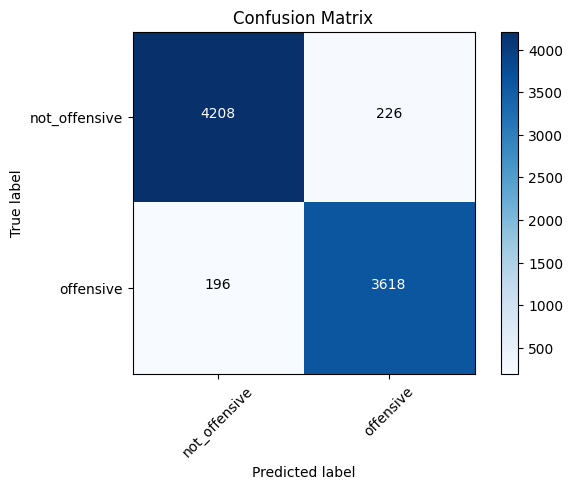

In [ ]:
#confusion matrix
lstm2_cm =confusion_matrix(y_test_argmax, lstm2_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm2_cm, classes=labels)

----

In [ ]:
# model prediction: BiLSTM3
lstm3_pred = lstm3.predict(x=x_test3, verbose=0)

#get argmax of predictions
lstm3_pred = np.argmax(lstm3_pred, axis=1)

#get argmax of actuals
y_test_argmax =np.argmax(y_test3, axis=1)

In [ ]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=lstm3_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.87      0.94      0.90      4434
    offensive       0.92      0.83      0.87      3814

     accuracy                           0.89      8248
    macro avg       0.89      0.89      0.89      8248
 weighted avg       0.89      0.89      0.89      8248



confusion matrix, without Normalized
[[4169  265]
 [ 642 3172]]


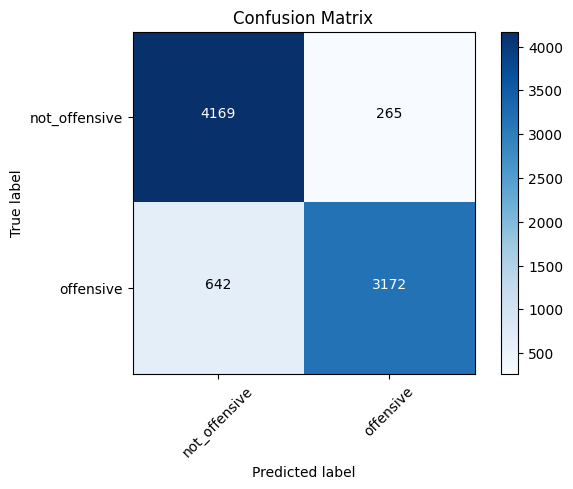

In [ ]:
#confusion matrix
lstm3_cm =confusion_matrix(y_test_argmax, lstm3_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=lstm3_cm, classes=labels)

---

### BERT

In [ ]:
# model prediction: BERT
bert_pred = bert.predict(x=x_test4, verbose=0)

#get argmax of predictions
bert_pred = np.argmax(bert_pred, axis=1)

#get argmax of actuals
y_test_argmax =np.argmax(y_test4, axis=1)

In [ ]:
#generate classification report
print(classification_report(y_true=y_test_argmax, y_pred=bert_pred, target_names=labels))

               precision    recall  f1-score   support

not_offensive       0.95      0.94      0.95      4434
    offensive       0.94      0.95      0.94      3814

     accuracy                           0.95      8248
    macro avg       0.95      0.95      0.95      8248
 weighted avg       0.95      0.95      0.95      8248



confusion matrix, without Normalized
[[4185  249]
 [ 199 3615]]


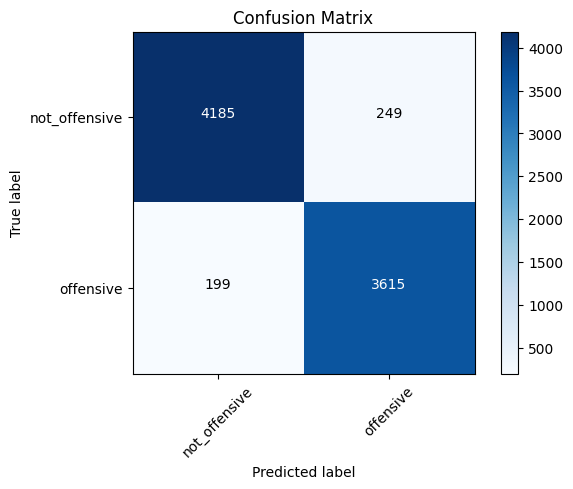

In [ ]:
#confusion matrix
bert_cm =confusion_matrix(y_test_argmax, bert_pred)

#plot confusion matrix for custom model
plot_confusion_matrix(cm=bert_cm, classes=labels)

---

## Compare models

In [ ]:
#compare models
w2v_acc, w2v_loss = lstm1.evaluate(x_test1, y_test1, batch_size=64)
glove_acc, glove_loss = lstm2.evaluate(x_test2, y_test2, batch_size=64)
ft_acc, ft_loss = lstm3.evaluate(x_test3, y_test3, batch_size=64)
bert_acc, bert_loss = bert.evaluate(x_test4, y_test4, batch_size=64)

129/129 [==============================] - 29s 229ms/step - loss: 0.1608 - accuracy: 0.9457


In [ ]:
#parse accuracies to dataframe
model_acc_df = pd.DataFrame({'word2vec':[w2v_acc, w2v_loss],
                             'glove':[glove_acc,glove_loss],
                             'fasttext':[ft_acc,ft_loss],
                             'BERT':[bert_acc,bert_loss]}, index=['loss','accuracy'])

model_acc_df

,word2vec,glove,fasttext,BERT
loss,0.286693,0.141667,0.276686,0.160846
accuracy,0.887245,0.948836,0.890034,0.945684


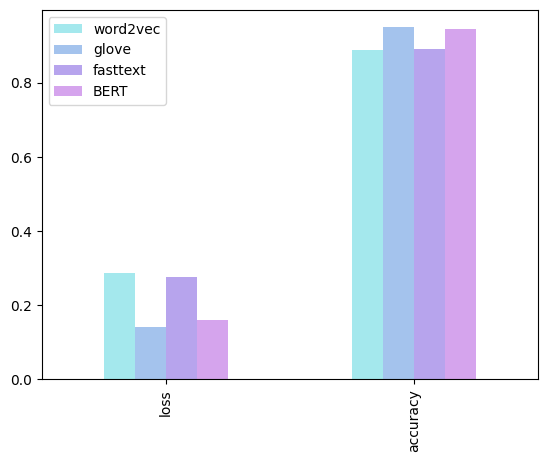

In [ ]:
#plot values
model_acc_df.plot.bar(color=['#a4e8ed','#a4c3ed','#b7a4ed','#d5a4ed'])
plt.show()


---

# Testing

In [ ]:
def predict_post(text):
    
    #clean text
    cleaned_text = clean_text(text)

    #get prediction
    pred = bert.predict([cleaned_text], verbose=0)

    labels = le.classes_
    return labels[np.argmax(pred)]

In [ ]:
text = 'happy'

In [ ]:
predict_post(text)

'not_offensive'

In [ ]:
text2 = 'That is good'

In [ ]:
predict_post(text2)

'not_offensive'

In [ ]:
text3 ='hoe'

In [ ]:
predict_post(text3)

'offensive'

In [ ]:
predict_post('stop acting like a fucking nigga')

'offensive'

In [ ]:
predict_post('bitch')

'offensive'